# TP3 - VANBELLE Julien

# Clustering de documents

## Imports

In [1]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [2]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julienvanbelle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data_path = "../data/txt/"

## Choisir une décennie

In [4]:
DECADE = '1960'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [5]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [6]:
# Exemple de fichiers
files[:5]

['Bxl_1960_Tome_II1_Part_1.txt',
 'Bxl_1960_Tome_II1_Part_2.txt',
 'Bxl_1960_Tome_II1_Part_3.txt',
 'Bxl_1960_Tome_II1_Part_4.txt',
 'Bxl_1960_Tome_II1_Part_5.txt']

In [7]:
texts = [open(data_path + f).read() for f in files]

In [8]:
# Exemple de textes
texts[0][:400]

'PUBLICATION\n\nPERIODIQUE\n\nVILLE DE BRUXELLES\n\nAnnée 1960\n\nBULLETIN\nCOMMUNAL\nTOME II "\n_u\n\nImpr. H . 6 M . S C H A U M A N S\nSociété\n\nAnonyme\n\nParvis Saint-Gilles, 41\nBruxelles\n1960\n\n\x0c\x0cN" 14\n\nCOMPTE\n\nR E N D U D E L A S E A N C E D U 1"\' A O U T\n\nVILLE\n\nDE\n\n1960\n\nBRUXELLES\n\nBULLETIN\n\nCOMMUNAL\n\n(Publication\n\npériodique)\n\nA n n é e 1960\n\nCONSEIL\n\nS é a n c e du\n\nPRESIDENCE\n\nCOMMUNAL\n\n1\n\ner\n\naoût\n\nDE M'

## Vectoriser les documents à l'aide de TF-IDF

In [9]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [10]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [11]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 1min 37s, sys: 1.14 s, total: 1min 38s
Wall time: 1min 44s


In [12]:
# Détail de la matrice
tfidf_vectors

<420x6466 sparse matrix of type '<class 'numpy.float64'>'
	with 574279 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [13]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

+considérant    0.300647
fer             0.228639
curage          0.207466
dma             0.153796
art             0.147675
                  ...   
engagé          0.000000
engager         0.000000
engagements     0.000000
engage          0.000000
™               0.000000
Length: 6466, dtype: float64

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [50]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [51]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [52]:
clusters = km_model.fit_predict(tfidf_vectors)

In [53]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [54]:
pprint(dict(clustering))

{0: ['Bxl_1960_Tome_II2_Part_7.txt',
     'Bxl_1960_Tome_II2_Part_8.txt',
     'Bxl_1960_Tome_II2_Part_9.txt',
     'Bxl_1960_Tome_I_Part_12.txt',
     'Bxl_1960_Tome_I_Part_13.txt',
     'Bxl_1961_Tome_II2_Part_7.txt',
     'Bxl_1961_Tome_II2_Part_8.txt',
     'Bxl_1961_Tome_I_Part_11.txt',
     'Bxl_1961_Tome_I_Part_12.txt',
     'Bxl_1962_Tome_II2_Part_8.txt',
     'Bxl_1962_Tome_II2_Part_9.txt',
     'Bxl_1962_Tome_I_Part_12.txt',
     'Bxl_1962_Tome_I_Part_13.txt',
     'Bxl_1963_Tome_II2_Part_11.txt',
     'Bxl_1963_Tome_II2_Part_12.txt',
     'Bxl_1963_Tome_I_Part_12.txt',
     'Bxl_1963_Tome_I_Part_13.txt',
     'Bxl_1964_Tome_II2_Part_10.txt',
     'Bxl_1964_Tome_II2_Part_11.txt',
     'Bxl_1964_Tome_I_Part_14.txt',
     'Bxl_1965_Tome_II2_Part_13.txt',
     'Bxl_1965_Tome_II2_Part_14.txt',
     'Bxl_1965_Tome_I_Part_13.txt',
     'Bxl_1965_Tome_I_Part_14.txt',
     'Bxl_1966_Tome_I2_Part_10.txt',
     'Bxl_1966_Tome_I2_Part_11.txt',
     'Bxl_1966_Tome_II2_Part_13.txt',
     

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [55]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [56]:
reduced_vectors[:10]

array([[-0.38270779, -0.30286385],
       [-0.46021062, -0.36440906],
       [-0.04160252,  0.07746346],
       [-0.42760871, -0.33991659],
       [-0.23794331, -0.10348268],
       [-0.10847717, -0.04634015],
       [-0.26295927, -0.19855908],
       [-0.30965079, -0.15191124],
       [-0.08371917, -0.01569845],
       [-0.09278385,  0.02179727]])

### Générer le plot

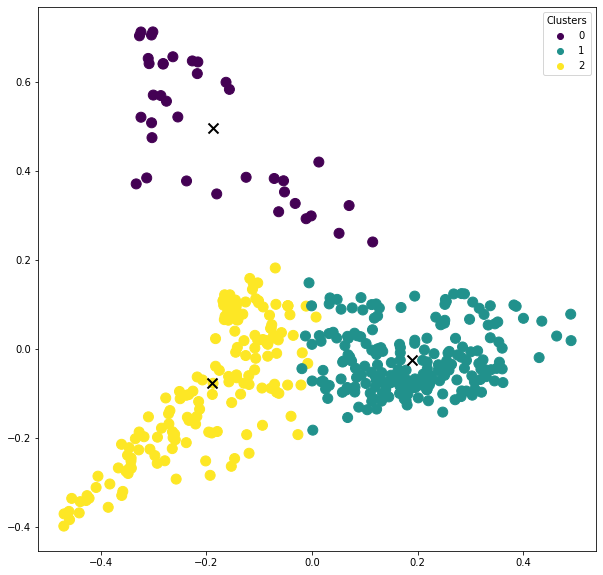

In [57]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")